#  Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import tensorflow_io as tfio
from tensorflow.keras import Model , layers, Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

In [3]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

# --- Normalización de imágenes a [0, 1] ---
def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# --- Conversión RGB->Lab y separación de Luminancia y ab ---
def rgb_to_lab_l_ab(image):
    lab_image = tfio.experimental.color.rgb_to_lab(image)
    # L canal [0, 100] → normaliza a [0, 1]
    L = lab_image[..., :1] / 100.0
    # ab canales [-128, 127] → normaliza a [0, 1]
    ab = (lab_image[..., 1:] + 128) / 255.0
    return L, ab  # (input, target)

# --- Pipeline final con shuffle, batch y prefetch ---
batch_size = 64

luminance_train_dataset = (
    train_dataset
    .map(rgb_to_lab_l_ab)
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

luminance_val_dataset = (
    val_dataset
    .map(rgb_to_lab_l_ab)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

luminance_test_dataset = (
    test_dataset
    .map(rgb_to_lab_l_ab)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Dataset listo con luminancia como input y ab como output.")

Found 21000 files belonging to 1 classes.
Found 3000 files belonging to 1 classes.
Found 6000 files belonging to 1 classes.
✅ Dataset listo con luminancia como input y ab como output.


In [6]:
def create_autoencoder(input_shape=(128, 128, 1)):
    model = tf.keras.Sequential([
        # Encoder
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        
        # Bottleneck
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Decoder
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        
        # Output → 2 canales (ab) para colorización
        layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')  # ab output
    ])
    return model

model = create_autoencoder((128, 128, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                        

In [7]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255)

In [8]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae", psnr, ssim]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_autoecoder_colorization.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]

history = model.fit(
    luminance_train_dataset,
    verbose=1,
    validation_data=luminance_val_dataset,
    epochs=50,
    callbacks=callbacks
)
save_path = "best_autoecoder_colorization.h5"


Epoch 1/50
329/329 [==============================] - 57s 146ms/step - loss: 0.0064 - mae: 0.0567 - psnr: 23.3226 - ssim: 0.6988 - val_loss: 0.0066 - val_mae: 0.0601 - val_psnr: 22.9140 - val_ssim: 0.7322 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 48s 140ms/step - loss: 0.0050 - mae: 0.0504 - psnr: 24.0938 - ssim: 0.7491 - val_loss: 0.0055 - val_mae: 0.0564 - val_psnr: 23.4236 - val_ssim: 0.7483 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 47s 140ms/step - loss: 0.0049 - mae: 0.0494 - psnr: 24.2654 - ssim: 0.7592 - val_loss: 0.0063 - val_mae: 0.0605 - val_psnr: 22.9811 - val_ssim: 0.7604 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 48s 140ms/step - loss: 0.0047 - mae: 0.0482 - psnr: 24.4504 - ssim: 0.7642 - val_loss: 0.0092 - val_mae: 0.0722 - val_psnr: 21.2898 - val_ssim: 0.7344 - lr: 0.0010
Epoch 5/50
329/329 [==============================] - 48s 140ms/step - loss: 0.0045 - mae: 0.0471 - psnr: 24.6207 - ssim: 0.7673

<Figure size 1200x600 with 0 Axes>

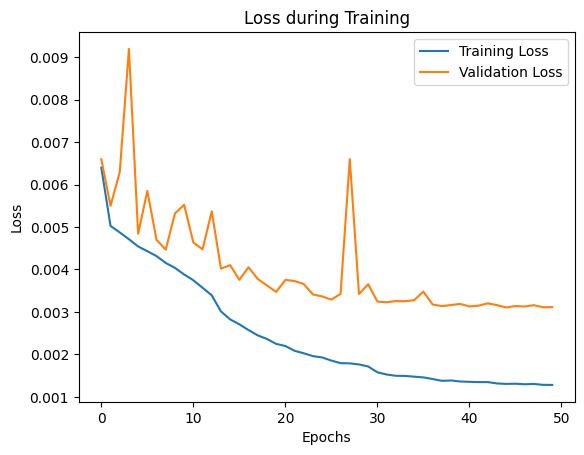

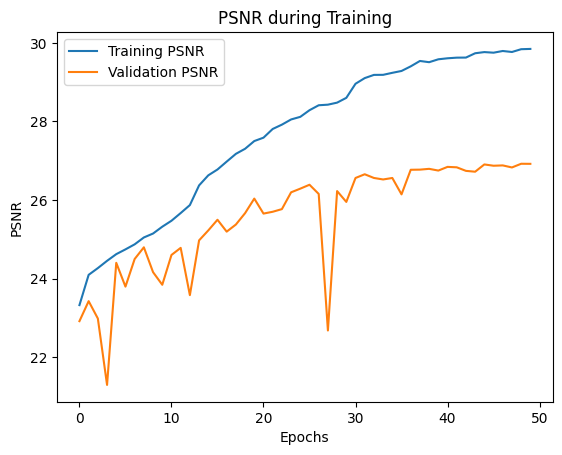

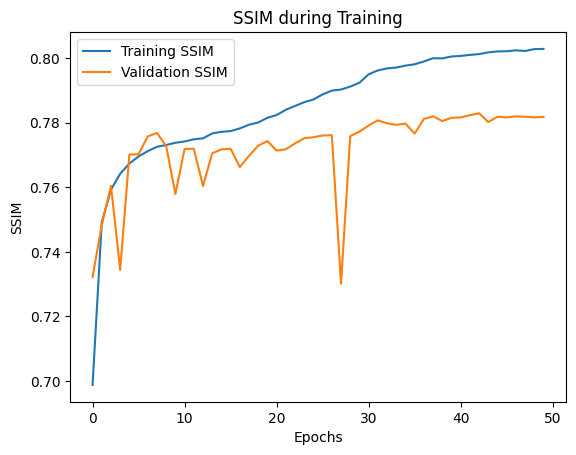

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

2/2 [==============================] - 0s 251ms/step


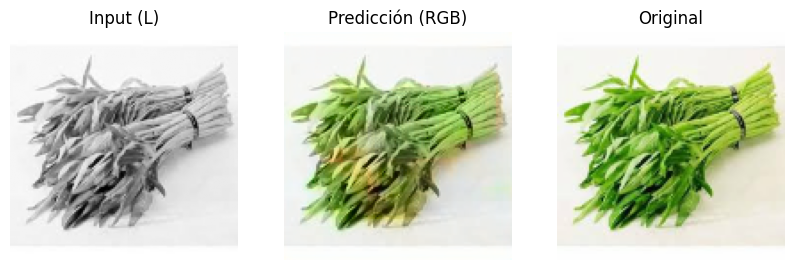

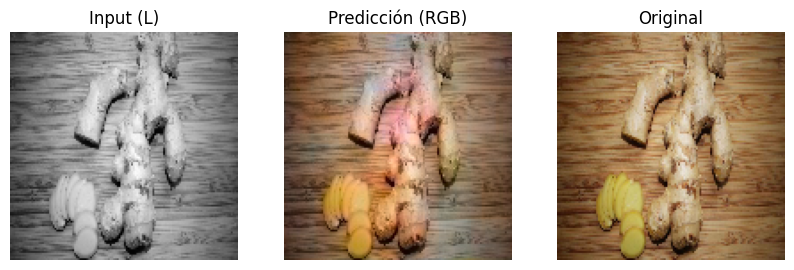

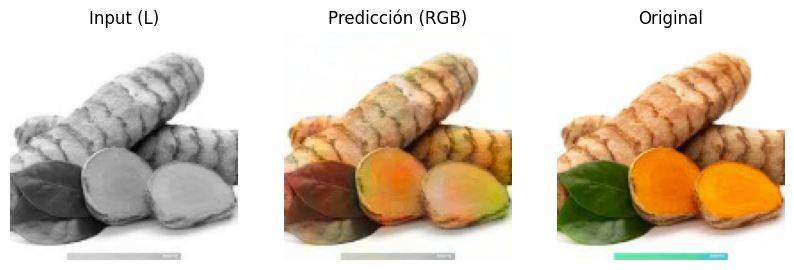

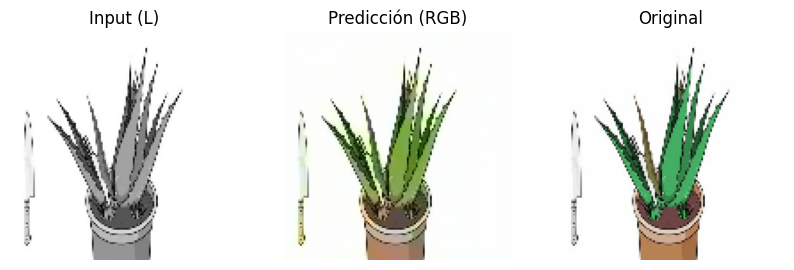

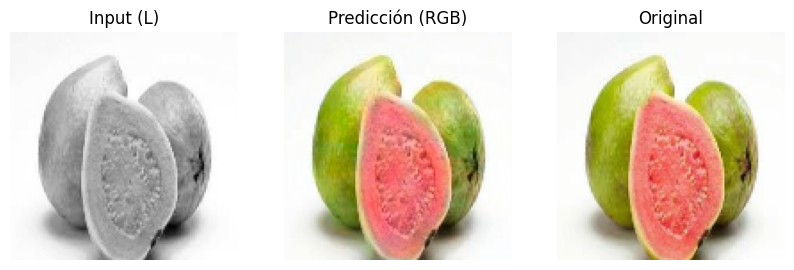

In [28]:
def show_colorization_examples(dataset, model, n=5):
    for L_input, ab_real in dataset.take(1):
        # Predicción del modelo
        ab_pred = model.predict(L_input)

        for i in range(n):
            plt.figure(figsize=(10, 3))

            # Input (Luminancia)
            L = L_input[i].numpy()
            plt.subplot(1, 3, 1)
            plt.imshow(L.squeeze(), cmap='gray')  # L tiene forma (128,128,1)
            plt.title("Input (L)")
            plt.axis("off")

            # Reconstruir RGB a partir de (L, ab_pred)
            lab_pred = np.concatenate([L, ab_pred[i]], axis=-1)
            lab_pred = lab_pred * [100.0, 255.0, 255.0]  # Desnormaliza
            lab_pred[..., 1:] -= 128.0
            rgb_pred = tfio.experimental.color.lab_to_rgb(lab_pred).numpy().clip(0,1)

            plt.subplot(1, 3, 2)
            plt.imshow(rgb_pred)
            plt.title("Predicción (RGB)")
            plt.axis("off")

            # Reconstruir RGB a partir de (L, ab_real) para referencia
            lab_real = np.concatenate([L, ab_real[i]], axis=-1)
            lab_real = lab_real * [100.0, 255.0, 255.0]
            lab_real[..., 1:] -= 128.0
            rgb_real = tfio.experimental.color.lab_to_rgb(lab_real).numpy().clip(0,1)

            plt.subplot(1, 3, 3)
            plt.imshow(rgb_real)
            plt.title("Original")
            plt.axis("off")

            plt.show()
show_colorization_examples(luminance_val_dataset, model, n=5)

In [19]:
# --- Convierte RGB a escala de grises (L) para el encoder ---
def rgb_to_luminance(image, label):
    gray = tf.image.rgb_to_grayscale(image)  # convierte a (batch, 128, 128, 1)
    return gray, label

# --- Pipeline adaptado ---
classification_train_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        directory="e:/TFM/PlantsClassification/train",
        image_size=(128, 128),
        batch_size=64,
        label_mode="int",
        color_mode="rgb",
        shuffle=True
    )
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normaliza
    .map(rgb_to_luminance)  # convierte a L
)

classification_val_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        directory="e:/TFM/PlantsClassification/val",
        image_size=(128, 128),
        batch_size=64,
        label_mode="int",
        color_mode="rgb",
        shuffle=False
    )
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .map(rgb_to_luminance)
)

classification_test_dataset = (
    tf.keras.utils.image_dataset_from_directory(
        directory="e:/TFM/PlantsClassification/test",
        image_size=(128, 128),
        batch_size=64,
        label_mode="int",
        color_mode="rgb",
        shuffle=False
    )
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    .map(rgb_to_luminance)
)


Found 21000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.


In [31]:
model = tf.keras.models.load_model("best_autoecoder_colorization.h5", custom_objects={'psnr': psnr, 'ssim': ssim})
autoencoder=model
autoencoder.trainable = False
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                        

In [34]:
def get_encoder(autoencoder):
    # Extraemos las capas del encoder (hasta MaxPooling2D final)
    encoder = tf.keras.Sequential(autoencoder.layers[:13])
    return encoder

encoder = get_encoder(autoencoder)

# Descongelar las dos últimas capas del encoder
encoder.layers[-1].trainable = True
encoder.layers[-2].trainable = True
encoder.layers[-4].trainable = True
encoder.layers[-3].trainable = True

# ✅ Importante: construir el modelo para que funcione el summary
encoder.build(input_shape=(None, 128, 128, 1))

encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                     

In [37]:
def create_classifier(encoder, num_classes=30, train_encoder=False):

    model = tf.keras.Sequential([
        encoder,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # 🚀 Importante: construirlo explícitamente
    model.build(input_shape=(None, 128, 128, 1))
    return model


In [38]:


classifier = create_classifier(encoder, num_classes=30, train_encoder=False)
classifier.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 16, 16, 128)       1258112   
                                                                 
 global_average_pooling2d_2   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 512)            

In [ ]:
#load the best autoencoder



classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history=classifier.fit(
    classification_train_dataset,  # dataset con labels
    validation_data=classification_val_dataset,
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_classifier.h5", save_best_only=True)
    ]
)
# save
classifier.save("best_classifier_Autoencoder.h5")



Epoch 1/50
329/329 [==============================] - 14s 39ms/step - loss: 2.3859 - accuracy: 0.3537 - val_loss: 1.6260 - val_accuracy: 0.5437
Epoch 2/50
329/329 [==============================] - 12s 37ms/step - loss: 1.4998 - accuracy: 0.5604 - val_loss: 1.4348 - val_accuracy: 0.5990
Epoch 3/50
329/329 [==============================] - 12s 37ms/step - loss: 1.0354 - accuracy: 0.6832 - val_loss: 1.4776 - val_accuracy: 0.6163
Epoch 4/50
329/329 [==============================] - 12s 37ms/step - loss: 0.7210 - accuracy: 0.7697 - val_loss: 1.5915 - val_accuracy: 0.6127
Epoch 5/50
329/329 [==============================] - 12s 37ms/step - loss: 0.5200 - accuracy: 0.8260 - val_loss: 1.4839 - val_accuracy: 0.6733
Epoch 6/50
329/329 [==============================] - 12s 37ms/step - loss: 0.4095 - accuracy: 0.8590 - val_loss: 1.5913 - val_accuracy: 0.6703
Epoch 7/50
329/329 [==============================] - 12s 37ms/step - loss: 0.3178 - accuracy: 0.8836 - val_loss: 1.5032 - val_accuracy:

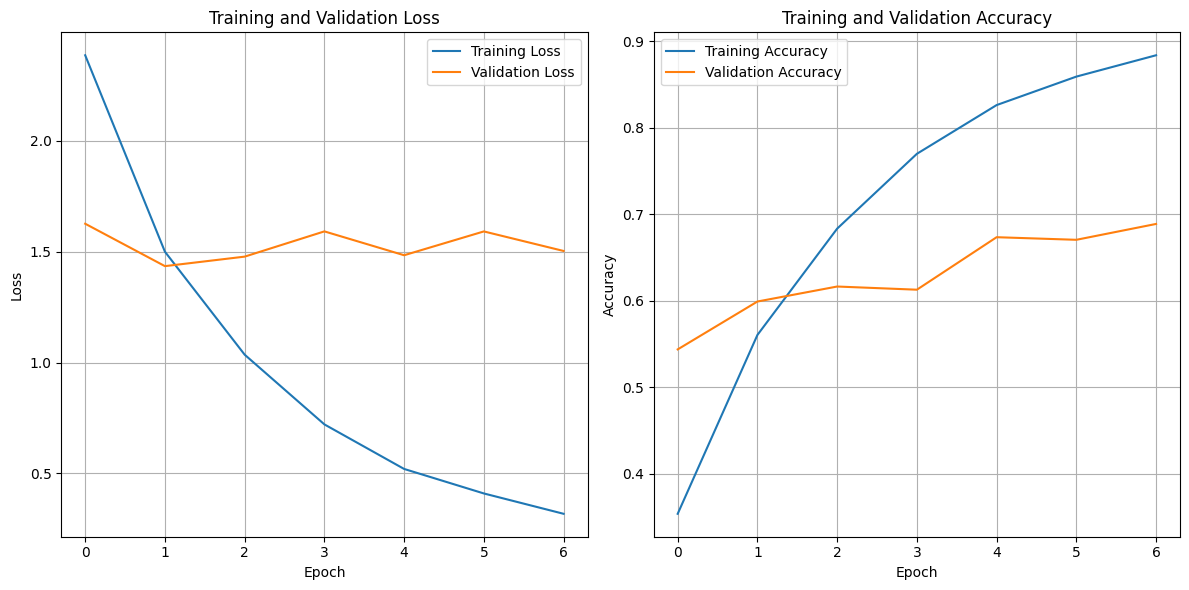

In [40]:
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 16ms/step
Accuracy: 59.90%


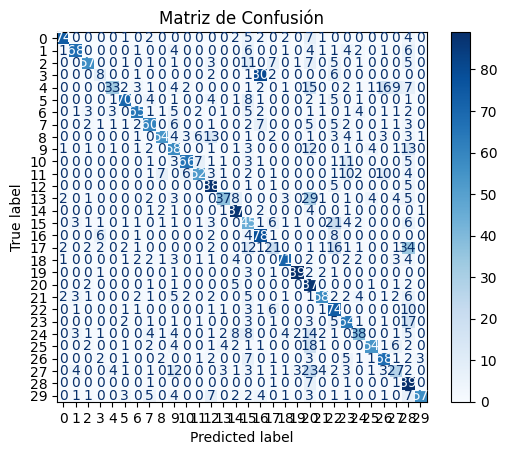

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in classification_val_dataset:
    predictions = classifier.predict(images)  # Use the classifier model
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Convertir y_true y y_pred a arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Crear la matriz de confusión
num_classes = len(np.unique(y_true))  # Determinar dinámicamente el número de clases
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()